# Signal modelling and source separation - GSMM models

This notebook trains signal models and performs source separation for multiple signals.

The signal model is given as
$$ To appear soon (hopefully) $$

The observation model is given as
$$ p(y_k \mid x^{1:N}_k) = \mathcal{N}\left(y_k \mid \sum_{n=1}^N x^n_k, \ \gamma_y^{-1}\right)$$



## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
using Random
using Printf
using BenchmarkTools
using HDF5
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [3]:
# signal definition
sound_files = ["../data/woman.wav",            # specify sound sources to model and separate (can be more than 2)
               "../data/obama.wav"]
fs_desired = 8000                              # specify desired sampling frequency of signals
duration_train = 3                             # specify duration of training signals
duration_sep = 5                               # specify duration of mixture signal
normalization_method = "max"                   # specify method to use for normalizing the signals

# save folders
folder_params = "inferred/GSMM_model"          # specify folder to save inferred values in (to save time when recomputing)
folder_figures = "figures/GSMM_model"          # specify folder to save figures in

# inference and modelling
nr_clusters = [7,7]                            # number of clusters in GSMM (if you want to use 2 orders: see footnote below notebook)
nr_freqs = 24                                  # number of frequencies in log-power domain (excluding DC and fs/2)
overlap_train = 0.5                            # portion of overlap during training
overlap_sep = 0.0                              # portion of overlap during source separation
iterations = 10                                # number of iterations for variational message passing
Σ_meas_train = 1e-5                            # assumed precision of measurement noise during training
Σ_meas_sep = 1e-4                              # assumed precision of measurement noise during source separation
window=rectangularwindow                       # specify windowing function
;

In [4]:
# auxiliary variables
bufsize = 2*(nr_freqs+1)                                                             # size of time-domain buffer
stepsize_train = Int(round(bufsize*(1-overlap_train)))                               # stepsize during training
stepsize_sep = Int(round(bufsize*(1-overlap_sep)))                                   # stepsize during source separation
nr_samples_train = Int((fs_desired*duration_train-bufsize)/stepsize_train) + 1       # number of samples during training
nr_samples_sep = Int((fs_desired*duration_sep-bufsize)/stepsize_sep) + 1             # number of samples during source separation
freqs = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs_desired)[2:end-1]                # frequencies of probabilistic Fourier transform
;

## Load and preprocess data

In [5]:
# create array for time signals and log-power signals
signal = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_z = Array{Array{Float64,2},1}(undef, length(sound_files))

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_train)*fs_tmp]
    
    # preprocess signal and save
    signal[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
    
    # take windowed fft of signal
    signal_tmp = FFTovertime(signal[k], bufsize, bufsize-stepsize_train, window)

    # reduce fft
    signal_tmp =  hcat(real.(signal_tmp[:,1]), 2*real.(signal_tmp[:,2:nr_freqs+1]), real.(signal_tmp[:,nr_freqs+2]), -real.(signal_tmp[:,1]), -2*imag.(signal_tmp[:,2:nr_freqs+1]), imag.(signal_tmp[:,nr_freqs+2]))

    # get the log abs values
    signal_z[k] = log.(abs2.(signal_tmp[:,2:nr_freqs+1]) + abs2.(signal_tmp[:,nr_freqs+4:end-1]))
        
end

# create mixture signal 
ymix = zeros(bufsize*nr_samples_sep)
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_sep)*fs_tmp]
    
    # preprocess signal and save
    ymix = ymix + preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)

end

# calculate low-power spectrum of mixture signal
zmix = FFTovertime(ymix, bufsize, bufsize-stepsize_sep, window)
zmix =  hcat(real.(zmix[:,1]), 2*real.(zmix[:,2:nr_freqs+1]), real.(zmix[:,nr_freqs+2]), -real.(zmix[:,1]), -2*imag.(zmix[:,2:nr_freqs+1]), imag.(zmix[:,nr_freqs+2]))
zmix = log.(abs2.(zmix[:,2:nr_freqs+1]) + abs2.(zmix[:,nr_freqs+4:end-1]))

# create time axis
t_train = collect(1:length(signal[1]))/fs_desired
t_sep = collect(1:length(ymix))/fs_desired
;

## Visualise signals

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDeGCG+wHJcvpCsGr6ixAK+A3W1vZxHMLwrUcM98JIxPuc6hz4v4rA+unPDPsMfuD4Q3bE+DGdePvco9Tx16ju9Ir4bvXWXJL4aCpa+tNl5vqmb4L2Bf5C9G/98vfNcALo0wpA9ATiNPR/00zxiisy886Wdvb5dwr0tT/+9tnYzviMdWb4ejzG+b/r3vV/vwr2bX4K9rMM4PadMMj4bDYM+MZedPu+jvT7ttcM+jtK7Ph2Fez5VY3M9UpMjvZUQIb2Qxxq+6x2avjUQkb7yfhG+ny2WvXbAs70FmBe9eiN3PQPkuD39k189g9SXPG67zrzW/5K9eYDmvdo4GL4uKk6+HcdIvrpwHL4rqei9V3aCvSDOcT19yk8+phiSPm2xqz6Nn8s+MBjWPjzBpD4jDuM9kcpPPNEtWjkJ7OW9LSaevrQCqr6Cnkm+mnX/vV/uFr7MH9W9c9gePd35Az4HYL49mRf1PCwOpTzvFSA9dVHPvPGsDr7cG0i+X2wvvhQCHb5DcB2+tLj9vRKY4bsisQw+g9h1PuGgkT5LWa8+Pl7PPqpdvT7+YkY+O86qPGk40juD1PS8IzphvlGRuL5lDYq+Gk8lvrzPKL4kTya+dqpZvXeGTD1ZXKE9IhJiPZqXqTxSzMs7Uhe7PM820LzfzAm+ljgfvnlrmr3hRCS9CbQxvQ2PlT2ij4U+cpywPveHsD5RtbI+UZluPrSN0j3Pe5M9C3JNvDMncb7zT6G+YONevpqsPr4fGXG+IAU1viAbsbzr55M9i5LJPQ+T/j0JjMk9huyCPcfRjD0ShN48dkD1vWc5Vr59Dh2+L+EKvgp1Wr5bmki+SwFUvVNzRT245Yg930cFPiLVYT5CK4Y+pSBpPivyPj5FPxY+3YHIPVP+Az04wyW9RB93vUgvhL2/SPq95mkwvqan/r0la629h/zVvU5dyL1ujJC8yzl/PKJbxLwX0k29CxEZvXHXvryl5cC8fBRzvPu3mTyj1cc9kSZEPnHygz49N5g+Pa62PqyKoD6zGMQ95g91vNK5ED1pm3u9FQegvndCpr48thO+7A4FviuEa75WfQi+KsqRPehfDz73VtU9yoIGPm5/Pj6VQTk+ScHsPdv1rjxahWG9jWS/vdhl2L3oNii+YDBQvpVBIb5ED5e9aoR8vQspYb2qbX85tTmFPVQ2gD1ZFxo9rF0ZPXOVHj3I7RE8SSgrvbM9Vb08pRG9mwruvKUKJb3g5Rq940HevMTEDLsdyRg8EixtO9Er1Lu7p/07gelPPDHzErxTOA29dNvcvNyUDbxieaa8Pi46vFhcmDz0IBQ9hJkLPU0/QT09nnE9JeiHPfkRXT3jDxU9SbvKPKwrnzzhdUE7dmUMvUG/R73DkD+9y9BrvfZVob1jZ4m93S9VvZUVVb18/k29miz6vHgcpLwA2Ja84hvVu+kH/ztvHX08nKn7PFvGcT3mkoc9aeGMPU9cvD1Xgdk9C326PUxVkD0qqEk959oIPTMvUrthYzK9Nai0vVPo7L2uOvq9QjT6vT3ADb664wa+EcK8vX8Pir1FpV69GHXvvAu4IzpBx5g8X6cZPa5MST0VRXs9WHfGPQ38DT4TSSY+lvU+PlZ3RD5LAR4+w3S8PZpbiz0HfoS7IuPgvRgBJL6kpB++e5xBvsoMcr5lYEy+WesHvk+g5r0cK9G9WU4nvVu4jTw/qgo9nbhFPa/xpD1VKt495enwPceYDz4R6Do+U+piPocTdT4C6zA+LoZYPUjNAj11a1w9lxNgvUkOS758vBq+lBmQvQ8SHb5LAFC+MEqtvcGEvTuufx69+eKYvK2HqT0Rbdw9rtZpPSJ+bT3q8KQ9FtgGPQEhBL3g0Be9JHcgvdMypr18Es69Dbe1vdVupL2Tn5O9aJNdve6P8ryl+Ue85dxtvJ4rO7zsvo86hkmLPGfggDvfICu8rWqVO9o5GDw1Uiy8/oUdvEur/jsBg8S7TbedvC5Pa7w0Mxq8E+YbvAinobv4s4k7gyreO6heFTwlLS08PfBiPF/qDz1+LRw953C+PDJmkTzAtQM9eiXrPD72gTx+uLY8+YbHPO1OBDysghu6eBhTOVHe6LsIhhC8XfgYvMHcB7z/TQu80WgLvHkDLbqhSyW7aAEWO8Gz/Tv307I7ENtYPJ2vvzwwpEk8cKVwPJW49TzzeKc8TJOyO1qchTwWe+48QMeJPLBECjzdQPA70AsYupKyHDy2now8XYsRvBHVL7w14lk8DC0wPDOkB7xtwyw7Ave+O4nQijoQRx88te/YO2TsNzoII+47eLqIPOv9Ejx36gU7kpNqPCjMADwo7Ks81vk7PL4oTTqxEgA9CyWEPD+1GTx8w9c8QIx6Owt4bDq2t8U8DPlBPEFjkryEA8q7EVItOT5cdrzFcRm7dUu9OjJGObxfxSg8MRrNu2l28Lxz7Yc8CAAAPTeKkry5ViK9gOpWPAyQEz0SK/W8m1fDvI2iHT2Ht6e86FgDvS9SJT3SpiO7Jh1zvdXmZzuoNqY8Q08Uvb3rJ73msqK7LyM1vOOq0LxKA/e7yXrhvFIbcLx5GLU8IpyOvCD+Rr0uA4s8ogw2POFFFb0IIE287JPSO/8HNbyrwcO8Q0mau6UKPTsOLde8pWCzvEfH0rtb6+O7OIHQvOJXwLy9Evu7KypjvMuzM7wr1/C7M50Lu7Bv4bqa8le7v3Rfu5GTfTpEv4A7mQ7LuziLjbsbq1W6ND95urs1XbtQghe8iW2mu9KYuLslp564bQnJOstdNjrMlNI5vbPVOzW5Ljrxoqe7DHUQu1oA0buNvCi8S8ksvHsKC7yPlim89PGDvPXGOrw3EuW7bwPCugBRfLvQ1kw6o2wsPGP7HzwokZA7cvPROzsrCzwE3nI7EWJAO2q7RTsJyIg4JAuQOpbio7gNo4W6jOu3uiU6z7q/9hc77AL6OWy8tLvuyr27amr2u4R0CLyeYwq8VS32u0VV7bqbbmY6HEq1Oyb1/Tq+iII6z7n4O5VsDjzo9Dk7zZQXukxDvju/oMk7nezZuvlIdLk+D8s7iaLFO6PVHTqyRF86+Q7MO0FO0Tvd5go8L8YePHWXSzzM7iQ8cx09PCxRGzxEjfk7a70TPJIssztcXh87jGrQOxmkzDvgYjY8qcEePJys4DtJeAQ83YgBPLMx3zvnZsQ7Lz4RPL/xQjylhNg7OXmmO4yEFjzrqfY75sokPEIIgjz3IFg8FNIUPH4DJjzyciQ8zrg3OwJ91DusQok6PC+kuz364rsf+9K7BGN9uzFXvLsrCpk50diSO5Gh7TpVY4I6MX83O4W95Tr86G67nr7Vu3DzD7wZDiq8bDsovCP1b7znjY68s0KJvItIeLz/gJy89RR1vEECVbzK4YK8muiFvOcXhbxjeYe8Z1WovHutm7xSbK+8gKyvvNkcqrzFRJ68ReGsvC6xorz5xTa8i8WCvIMEfbyFSFW8y1pHvJ/0SLyXoZq8GmudvH3OpbzYEom84gt+vDzagbxlKX684VlsvJlSgbwoEpG817WMvM94QLwROVe8OjF7vHmaPrxxvA28bXQovEn+0rv6j5u7qO4ovNUdF7xz5Ke7W86Au81Yf7su36K7qXzHuw+EJrfTitO6bfq5uTWZzDpJppI62qR4O2LfDDtCO6Y6O8iSO8GK4LrDTI+7QfPHOpu/OzqKXhE7Tz6nOoT52DvjTbU74uOMO9gvETzT7yc8g6ASPLuxfDzFeDw83kw2PGHvJTxN+RU8DYo6PHmgADwCvUo8BhAaPPgc7Tv7dgA8M+ZPPNzmQTyWYBo8WKJmPL0iZjxU3ws8c1YyPKAmYjyOm4E8MnKFPJUvfDyukGg8t7aEPPR3nDwtSGg8u0E2PL4lajz3Y

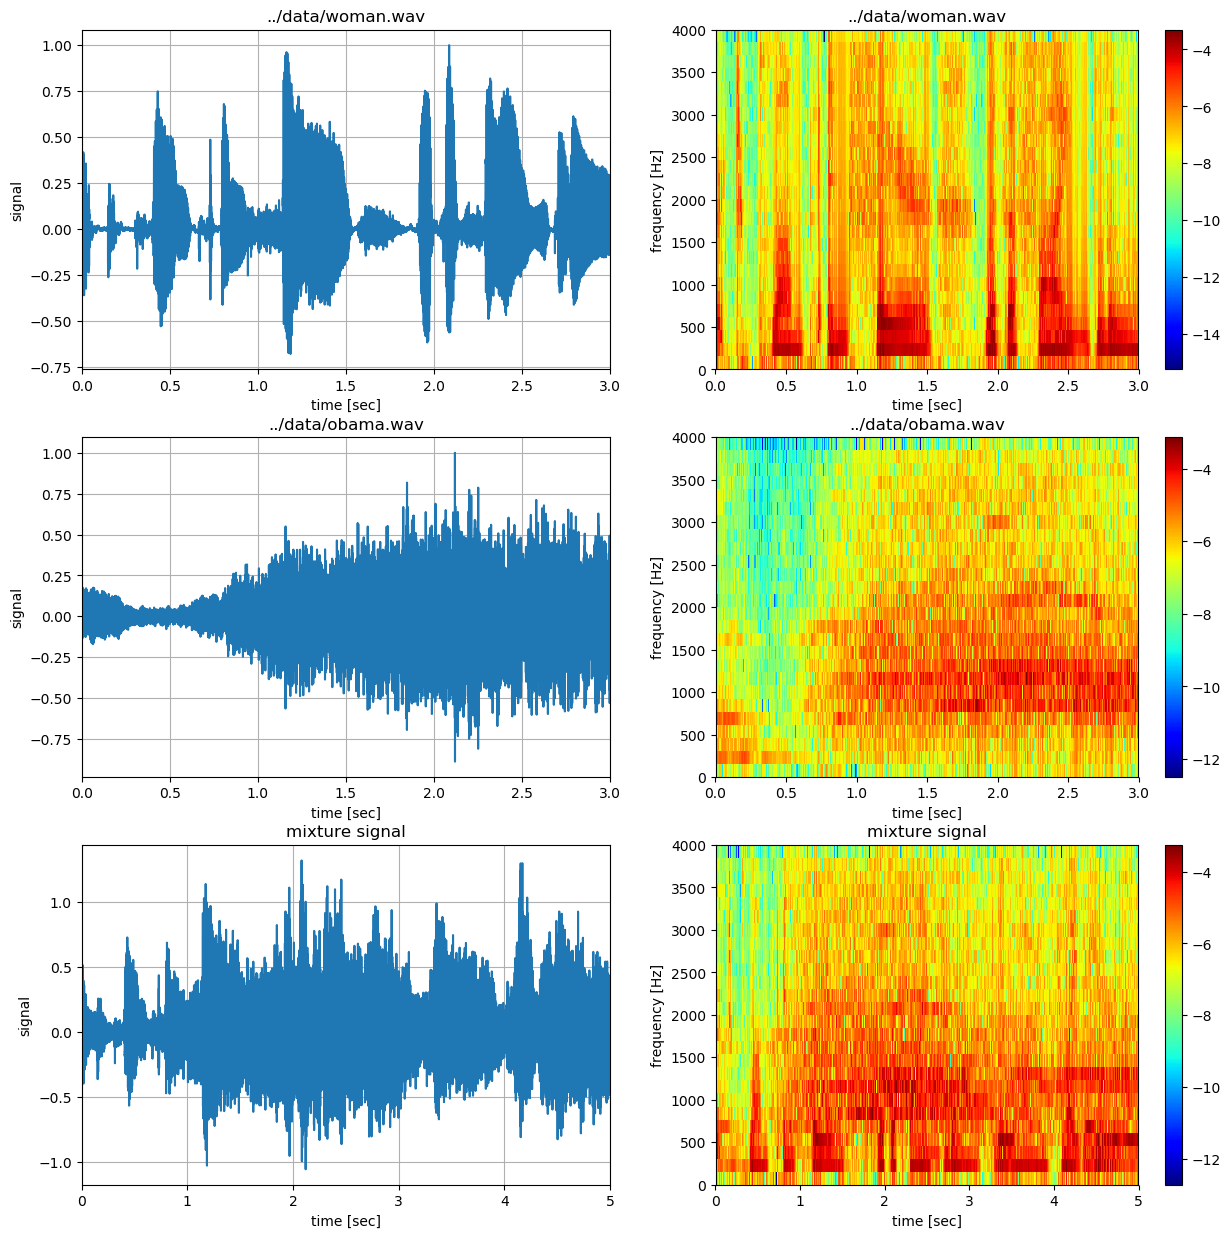

In [6]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files)+1, figsize=(15, 5*(length(sound_files)+1)))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_train, signal[k]), ax[k,1].set_xlim([0, duration_train]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k])
    
    # plot spectrogram of signal
    plot_spectrogram(spectrogram(signal[k], bufsize, bufsize-stepsize_train, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true), ax[k,2].set_title(sound_files[k])

end

# finally add mixture signals
ax[end,1].plot(t_sep, ymix), ax[end,1].set_xlim([0, duration_sep]), ax[end,1].set_xlabel("time [sec]"), ax[end,1].set_ylabel("signal"), ax[end,1].grid(), ax[end,1].set_title("mixture signal")
plot_spectrogram(spectrogram(ymix, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[end,2], colorbar=true), ax[end,2].set_title("mixture signal")

# create audioplayers
audioplayers(signal..., ymix, fs=fs_desired)
;

## Define signal model

In [7]:
# create expression that can draw an entire graph in a factor graph statement
function signal_model(k, nr_clusters, nr_freqs, bufsize)
    
    # wrap code into an expression to execute later on in a factor graph type to allow for modularity
    model = quote
        
        # create dictionary for variables
        if !@isdefined vars
            vars = Dict()
        end
        
        # create mixture components
        for ki = 1:($nr_clusters)

            # specify distribution over precision matrix
            @RV vars[pad(pad(:w,ki),$k)] ~ Wishart(placeholder(pad(pad(:V_w,ki),$k), dims=($nr_freqs,$nr_freqs)), placeholder(pad(pad(:nu_w,ki),$k)))

            # specify distribution over mean
            @RV vars[pad(pad(:m,ki),$k)] ~ GaussianMeanPrecision(placeholder(pad(pad(:μ_m,ki),$k), dims=($nr_freqs,)), vars[pad(pad(:w,ki),$k)])

        end

        # specify distribution over categorical distribution
        @RV vars[pad(:π,$k)] ~ Dirichlet(placeholder(pad(:α_π,$k), dims=($nr_clusters,)))

        # specify distribution over selection variable
        @RV vars[pad(:z,$k)] ~ Categorical(vars[pad(:π,$k)])

        # create gaussian mixture model
        @RV vars[pad(:ξ,$k)] ~ GaussianMixture(vars[pad(:z,$k)], expand([[vars[pad(pad(:m,ki),$k)], vars[pad(pad(:w,ki),$k)]] for ki=1:($nr_clusters)])...)

        # log-power to complex fourier coefficients transform
        @RV vars[pad(:Xc,$k)] ~ ComplexHGF(vars[pad(:ξ,$k)])

        # complex fourier coefficients to real and imaginary parts concatenated
        @RV vars[pad(:Xr,$k)] ~ ComplexToReal(vars[pad(:Xc,$k)])

        # probabilistic Fourier transform
        @RV vars[pad(:x,$k)] = placeholder(pad(:C,$k), dims=($bufsize, 2*($nr_freqs)))*vars[pad(:Xr,$k)]

        # create recognition factor ids
        q_ids = vcat(:Π,
                     expand([[pad(:M,ki), pad(:W,ki)] for ki=1:($nr_clusters)]),
                     :Z, :Xc, :Ξ)

        # specify posterior factorization
        q = PosteriorFactorization(vars[pad(:π,$k)],
                                   expand([[vars[pad(pad(:m,ki),$k)], vars[pad(pad(:w,ki),$k)]] for ki=1:($nr_clusters)])...,
                                   vars[pad(:z,$k)], vars[pad(:Xc,$k)], vars[pad(:ξ,$k)],
                                   ids=q_ids)
        
    # end expression
    end 
       
    # return expression
    return model
    
end
;

## Train models or load parameters

In [8]:
function load_priors(k, signal_z, nr_clusters; mode="training")
    
    # create dictionary of priors
    if mode == "training"
        
        # train gaussian mixture model on deterministic log-power spectrum
        g = GMM(nr_clusters, signal_z, nIter=50, nInit=100, kind=:diag)
        em!(g, signal_z)
        
        # extract priors for π and z
        ll = llpg(g, signal_z)
        llmin = maximum(ll, dims=2)
        llnorm = ll .- llmin
        znorm = exp.(llnorm) ./ sum(exp.(llnorm), dims=2)
        α_π_min = squeeze(sum(znorm, dims=1))
        p_z_min = exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))) ./ sum(exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))))
        
        # specify priors
        priors = Dict()
        for ki = 1:nr_clusters
            priors[pad(pad(:μ_m,ki),k)] = g.μ[ki,:]
            priors[pad(pad(:nu_w,ki),k)] = g.d
            priors[pad(pad(:V_w,ki),k)] = diagm(1 ./g.Σ[ki,:]) / g.d
        end
        priors[pad(:α_π,k)] = α_π_min
        priors[pad(:p_z,k)] = p_z_min # only used for initializing the marginals
        
        
    elseif mode == "separation"
        priors = Dict()
        for ki in k
            println("todo")
        end
    end
    
    # return priors
    return priors
    
end
;

In [9]:
function load_marginals(k, nr_clusters, nr_freqs, data, signal_z, ind; mode="training")
    
    # create dictionary of marginals
    marginals = Dict()
    for ki in k
        for m = 1:nr_clusters[ki]
            marginals[pad(pad(:vars_m,m),ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(pad(:μ_m,m),ki)], w=data[pad(pad(:V_w,m),ki)]*data[pad(pad(:nu_w,m),ki)])
            marginals[pad(pad(:vars_w,m),ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(pad(:V_w,m),ki)], nu=data[pad(pad(:nu_w,m),ki)])
        end
        marginals[pad(:vars_π,ki)] = ProbabilityDistribution(Dirichlet, a=data[pad(:α_π,ki)])
        marginals[pad(:vars_z,ki)] = ProbabilityDistribution(Categorical, p=data[pad(:p_z,ki)])
        marginals[pad(:vars_Xc,ki)] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
        if mode == "training"
            marginals[pad(:vars_ξ,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=signal_z[ki][ind,:], v=1.0*diagm(squeeze(var(signal_z[ki], dims=1))))
        elseif mode == "separation"
            marginals[pad(:vars_ξ,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=signal_z[ind,:], v=1.0*Ic(nr_freqs))
        end
    end
    
    # return marginals
    return marginals
    
end
;

In [10]:
function train_model(k, model, priors, signal, signal_z, t_t, hyper, iterations, nr_clusters, freqs, bufsize)
    
    nr_freqs = length(freqs)
    
    # create factor graph
    FactorGraph()
    
    # create model
    eval(model)
    
    # add observation noise
    @RV y ~ GaussianMeanVariance(vars[pad(:x,k)], placeholder(:Σ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
    
    # create algorithm
    algo = variationalAlgorithm(q)
    source_code = compatibility_fix(algorithmSourceCode(algo))
    eval(Meta.parse(source_code))

    # create arrays for current estimates
    data = merge(priors, hyper)

    # get dictionary of currently inferred values 
    vals = Dict()
    
    # loop through data
    for n = 1:length(signal[k])
       
        # fill data dictionary
        data = merge(data, vals, Dict(:y => signal[k][n], (pad(:C,k)) => 1/bufsize*hcat(cos.(2*pi*freqs*t_t[k][n]')', sin.(2*pi*freqs*t_t[k][n]')')))

        # create marginals dictionary
        marginals = load_marginals(k, nr_clusters, nr_freqs, data, signal_z, n)
                
        # perform updates
        for _ = 1:iterations

            # perform updates
            Base.invokelatest(stepXc!, data, marginals)
            Base.invokelatest(stepΞ!, data, marginals)
            Base.invokelatest(stepZ!, data, marginals)
            Base.invokelatest(stepΠ!, data, marginals)
            for k = 1:nr_clusters[k]
                Base.invokelatest(getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!")), data, marginals)
                Base.invokelatest(getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!")), data, marginals)
            end

        end

        # get new values
        for m = 1:nr_clusters[k]
            vals[pad(pad(:μ_m,m),k)] = ForneyLab.unsafeMean(marginals[pad(pad(:vars_m,m),k)])
            vals[pad(pad(:nu_w,m),k)] = marginals[pad(pad(:vars_w,m),k)].params[:nu]
            vals[pad(pad(:V_w,m),k)] = marginals[pad(pad(:vars_w,m),k)].params[:v]
        end
        vals[pad(:α_π,k)] = marginals[pad(:vars_π,k)].params[:a]
        vals[pad(:p_z,k)] = exp.(ForneyLab.unsafeLogMean(marginals[pad(:vars_π,k)])) ./ sum(exp.(ForneyLab.unsafeLogMean(marginals[pad(:vars_π,k)])) )
        
    end

    return vals
    
end
;

In [11]:
# preprocess signal
signal_t = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
t_t = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))

shuff = randperm(nr_samples_train)
for k = 1:length(sound_files)
    signal_t[k] = [signal[k][(ki-1)*stepsize_train+1:(ki-1)*stepsize_train+bufsize] for ki = 1:nr_samples_train];
    t_t[k] = [t_train[(ki-1)*stepsize_train+1:(ki-1)*stepsize_train+bufsize] for ki = 1:nr_samples_train];
    signal_t[k] = signal_t[k][shuff]
    t_t[k] = t_t[k][shuff]
end
;

In [12]:
# create placeholder for parameters
params = Array{Dict, 1}(undef, length(sound_files))

# loop through signals
@showprogress for k = 1:length(sound_files)
    
    # check whether parameters have already been inferred
    filename = folder_params*"/GSMM_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(nr_clusters[k], pad=2)*"_"*string(nr_freqs, pad=2)*".h5"
    if isfile(filename)
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        println("For signal "*string(k)*" the parameters have been found and loaded.")
        
    else
        
        # train models and save parameters
        println("For signal "*string(k)*" the parameters have not been found and are now being trained...")
        
        # load graph
        model = signal_model(k, nr_clusters[k], nr_freqs, bufsize)
        
        # specify priors
        priors = load_priors(k, signal_z[k], nr_clusters[k]; mode="training")
        
        # specify hyperparameters
        hyper = Dict(:Σ_meas => Σ_meas_train*Ic(bufsize))
        
        # train model
        vals = train_model(k, model, priors, signal_t, signal_z, t_t, hyper, iterations, nr_clusters, freqs, bufsize)
        
        # save parameters
        h5open(filename, "w") do file
            for ki = 1:nr_clusters[k]
                write(file, "parameters/mu_m_"*string(ki), vals[pad(pad(:μ_m, ki), k)])
                write(file, "parameters/nu_w_"*string(ki), vals[pad(pad(:nu_w, ki), k)]) 
                write(file, "parameters/V_w_"*string(ki), vals[pad(pad(:V_w, ki), k)]) 
            end
            write(file, "parameters/alpha_pi", vals[pad(:α_π, k)]) 
        end
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        
        # return statement of completion
        println("For signal "*string(k)*" the parameters have now been trained and saved for later use.")
        
    end
    
end

For signal 1 the parameters have not been found and are now being trained...


┌ Info: Initializing GMM, 7 Gaussians diag covariance 24 dimensions using 959 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       7.715712e+04
      1       4.712602e+04      -3.003110e+04 |        7
      2       4.437982e+04      -2.746196e+03 |        7
      3       4.401267e+04      -3.671544e+02 |        7
      4       4.393836e+04      -7.430440e+01 |        4
      5       4.391978e+04      -1.858617e+01 |        4
      6       4.391808e+04      -1.701042e+00 |        2
      7       4.391777e+04      -3.047906e-01 |        2
      8       4.391681e+04      -9.572044e-01 |        2
      9       4.391519e+04      -1.620696e+00 |        3
     10       4.391312e+04      -2.072224e+00 |        2
     11       4.391278e+04      -3.368737e-01 |        0
     12       4.391278e+04       0.000000e+00 |        0
K-means converged with 12 iterations (objv = 43912.78379967671)


┌ Info: K-means with 959 data points using 12 iterations
│ 5.5 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139


For signal 1 the parameters have now been trained and saved for later use.

Progress:  50%|█████████████████████                    |  ETA: 0:04:00


For signal 2 the parameters have not been found and are now being trained...
  Iters               objv        objv-change | affected 
-------------------------------------------------------------
      0       6.873614e+04
      1       4.054936e+04      -2.818678e+04 |        7
      2       3.972975e+04      -8.196070e+02 |        7
      3       3.954856e+04      -1.811932e+02 |        7
      4       3.945071e+04      -9.784502e+01 |        7
      5       3.934731e+04      -1.034021e+02 |        7
      6       3.925214e+04      -9.517044e+01 |        6
      7       3.911873e+04      -1.334068e+02 |        6
      8       3.901805e+04      -1.006865e+02 |        6
      9       3.896795e+04      -5.010069e+01 |        6
     10       3.893065e+04      -3.729174e+01 |        5
     11       3.890626e+04      -2.439055e+01 |        5
     12       3.888855e+04      -1.771389e+01 |        4
     13       3.888155e+04      -7.001534e+00 |        5
     14       3.887674e+04      -4

┌ Info: Initializing GMM, 7 Gaussians diag covariance 24 dimensions using 959 data points
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:78


     2
     22       3.885373e+04      -7.849361e-01 |        0
     23       3.885373e+04       0.000000e+00 |        0
K-means converged with 23 iterations (objv = 38853.73137998798)


┌ Info: K-means with 959 data points using 23 iterations
│ 5.5 data points per parameter
└ @ GaussianMixtures C:\Users\s151781\.julia\packages\GaussianMixtures\3jRIL\src\train.jl:139
Progress: 100%|█████████████████████████████████████████| Time: 0:07:05


For signal 2 the parameters have now been trained and saved for later use.


## Visualize clusters

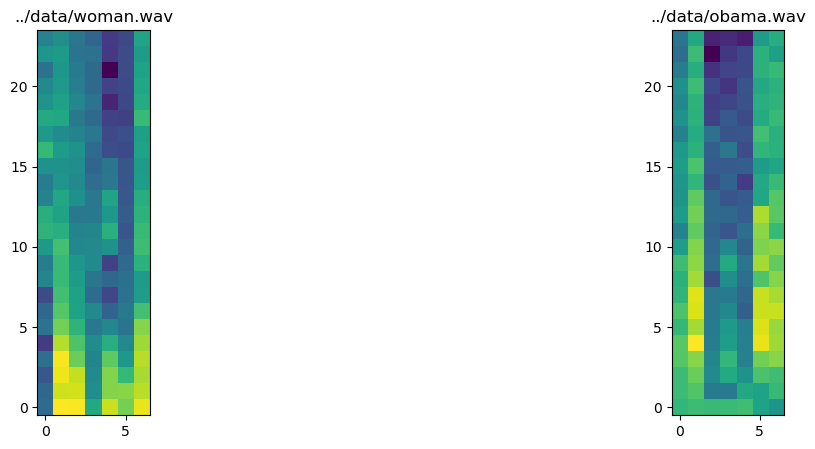

In [14]:
# plot new and previous means
_, ax = plt.subplots(ncols=length(sound_files), figsize=(15,5))
for k = 1:length(sound_files)
    ax[k].imshow(hcat([params[k]["mu_m_"*string(ki)] for ki=1:nr_clusters[k]]...), origin="lower")
    ax[k].set_title(sound_files[k])
end

## Perform source separation

In [15]:
function convert_parameters(params)
    params_new = Dict()
    for k=1:length(params)
        for ki = 1:nr_clusters[k]
            params_new[pad(pad(:μ_m,ki),k)] = params[k]["mu_m_"*string(ki)]
            params_new[pad(pad(:nu_w,ki),k)] = params[k]["nu_w_"*string(ki)]
            params_new[pad(pad(:V_w,ki),k)] = params[k]["V_w_"*string(ki)]
        end
        params_new[pad(:α_π,k)] = params[k]["alpha_pi"]
    end
    return params_new
end
;

In [16]:
function observation_model(k, nr_clusters, nr_freqs, bufsize)
    
    # create factor graph
    fg = FactorGraph()
        
    # create models and combine
    for ki = 1:k
        
        # create signal model
        model = signal_model(ki, nr_clusters[ki], nr_freqs, bufsize)
        eval(model)
        
    end
    @RV xtot = sum([vars[pad(:x, ki)] for ki=1:k])
    
    # add observation noise
    @RV y ~ GaussianMeanVariance(xtot, placeholder(:Σ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
        
    q_ids = vcat([pad(:Π,ki) for ki=1:k],
                 expand([expand([[pad(pad(:M,ki),kii), pad(pad(:W,ki),kii)] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
                 [pad(:Z,ki) for ki=1:k],
                 [pad(:Ξ,ki) for ki=1:k],
                 :Xc) # this variable is deterministically linked to all other signals. 

    q_i = vcat([vars[pad(:π,ki)] for ki=1:k],
               expand([expand([[vars[pad(pad(:m,ki),kii)], vars[pad(pad(:w,ki),kii)]] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
               [vars[pad(:z,ki)] for ki=1:k],
               [vars[pad(:ξ,ki)] for ki=1:k],
               [[vars[pad(:Xc,ki)] for ki=1:k]])
    
    q = ForneyLab.PosteriorFactorization(q_i..., ids=q_ids)
    
    return fg, q
    
end
;

In [17]:
signal_s = [ymix[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] for ki = 1:nr_samples_sep];
t_s = [t_sep[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] for ki = 1:nr_samples_sep];
;

In [18]:
# convert parameters
paramsc = convert_parameters(params)

# load graph
fg, q = observation_model(length(sound_files), nr_clusters, nr_freqs, bufsize)

# create algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))

# specify priors
#priors = load_priors(1:length(sound_files), AR_order, mode="separation")

# specify hyperparameters
hyper = Dict(:Σ_meas => Σ_meas_sep*Ic(bufsize))
hyper = merge(hyper, paramsc)

# create dictionary for to inferred values
vals = Dict()

# separated signals
μ_separated = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
Σ_separated = Array{Array{Array{Float64,2},1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_separated[k] = Array{Array{Float64,1},1}(undef, length(signal_s))
    Σ_separated[k] = Array{Array{Float64,2},1}(undef, length(signal_s))
end
p = Progress(length(signal_s))
# loop through signal
for n = 1:length(signal_s)
       
    # fill data dictionary
    data = merge( hyper, vals, Dict(:y => signal_s[n]))
    for ki = 1:length(sound_files)
        data[pad(:C,ki)] = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')
        data[pad(:p_z,ki)] = exp.(ForneyLab.digamma.(data[pad(:α_π,ki)]) .- ForneyLab.digamma.(sum(data[pad(:α_π,ki)]))) ./ sum(exp.(ForneyLab.digamma.(data[pad(:α_π,ki)]) .- ForneyLab.digamma.(sum(data[pad(:α_π,ki)]))))
    end
    
    # specify marginals
    marginals = load_marginals(1:length(sound_files), nr_clusters, nr_freqs, data, zeros(size(zmix)), n, mode="separation")

    # perform updates
    for _ = 1:iterations

        # perform inference
        Base.invokelatest(stepXc!, data, marginals)
        for ki = 1:length(sound_files)
            Base.invokelatest(getfield(Main, Symbol("stepΞ_"*string(ki,pad=2)*"!")), data, marginals)
        end
        for ki = 1:length(sound_files)
            Base.invokelatest(getfield(Main, Symbol("stepZ_"*string(ki,pad=2)*"!")), data, marginals)
        end
    end
    
    # get separated signals
    for ki = 1:length(sound_files)
        # complex to real
        μ_cx = ForneyLab.unsafeMean(marginals[pad(:vars_Xc,ki)])
        Γ_cx = ForneyLab.unsafeCov(marginals[pad(:vars_Xc,ki)])
        μ_rx = vcat(real.(μ_cx), imag.(μ_cx))
        V_rx = vcat(hcat(0.5*(real(Γ_cx)), zeros(size(Γ_cx))), hcat(zeros(size(Γ_cx)), 0.5*(real(Γ_cx))))

        C = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')
        # collidign messages is missing
        μ_separated[ki][n] = C*μ_rx
        Σ_separated[ki][n] = C*V_rx*C'
    end
    next!(p)
end    

Progress: 100%|█████████████████████████████████████████| Time: 0:02:48


## Analyze results

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDeGCG+wHJcvpCsGr6ixAK+A3W1vZxHMLwrUcM98JIxPuc6hz4v4rA+unPDPsMfuD4Q3bE+DGdePvco9Tx16ju9Ir4bvXWXJL4aCpa+tNl5vqmb4L2Bf5C9G/98vfNcALo0wpA9ATiNPR/00zxiisy886Wdvb5dwr0tT/+9tnYzviMdWb4ejzG+b/r3vV/vwr2bX4K9rMM4PadMMj4bDYM+MZedPu+jvT7ttcM+jtK7Ph2Fez5VY3M9UpMjvZUQIb2Qxxq+6x2avjUQkb7yfhG+ny2WvXbAs70FmBe9eiN3PQPkuD39k189g9SXPG67zrzW/5K9eYDmvdo4GL4uKk6+HcdIvrpwHL4rqei9V3aCvSDOcT19yk8+phiSPm2xqz6Nn8s+MBjWPjzBpD4jDuM9kcpPPNEtWjkJ7OW9LSaevrQCqr6Cnkm+mnX/vV/uFr7MH9W9c9gePd35Az4HYL49mRf1PCwOpTzvFSA9dVHPvPGsDr7cG0i+X2wvvhQCHb5DcB2+tLj9vRKY4bsisQw+g9h1PuGgkT5LWa8+Pl7PPqpdvT7+YkY+O86qPGk40juD1PS8IzphvlGRuL5lDYq+Gk8lvrzPKL4kTya+dqpZvXeGTD1ZXKE9IhJiPZqXqTxSzMs7Uhe7PM820LzfzAm+ljgfvnlrmr3hRCS9CbQxvQ2PlT2ij4U+cpywPveHsD5RtbI+UZluPrSN0j3Pe5M9C3JNvDMncb7zT6G+YONevpqsPr4fGXG+IAU1viAbsbzr55M9i5LJPQ+T/j0JjMk9huyCPcfRjD0ShN48dkD1vWc5Vr59Dh2+L+EKvgp1Wr5bmki+SwFUvVNzRT245Yg930cFPiLVYT5CK4Y+pSBpPivyPj5FPxY+3YHIPVP+Az04wyW9RB93vUgvhL2/SPq95mkwvqan/r0la629h/zVvU5dyL1ujJC8yzl/PKJbxLwX0k29CxEZvXHXvryl5cC8fBRzvPu3mTyj1cc9kSZEPnHygz49N5g+Pa62PqyKoD6zGMQ95g91vNK5ED1pm3u9FQegvndCpr48thO+7A4FviuEa75WfQi+KsqRPehfDz73VtU9yoIGPm5/Pj6VQTk+ScHsPdv1rjxahWG9jWS/vdhl2L3oNii+YDBQvpVBIb5ED5e9aoR8vQspYb2qbX85tTmFPVQ2gD1ZFxo9rF0ZPXOVHj3I7RE8SSgrvbM9Vb08pRG9mwruvKUKJb3g5Rq940HevMTEDLsdyRg8EixtO9Er1Lu7p/07gelPPDHzErxTOA29dNvcvNyUDbxieaa8Pi46vFhcmDz0IBQ9hJkLPU0/QT09nnE9JeiHPfkRXT3jDxU9SbvKPKwrnzzhdUE7dmUMvUG/R73DkD+9y9BrvfZVob1jZ4m93S9VvZUVVb18/k29miz6vHgcpLwA2Ja84hvVu+kH/ztvHX08nKn7PFvGcT3mkoc9aeGMPU9cvD1Xgdk9C326PUxVkD0qqEk959oIPTMvUrthYzK9Nai0vVPo7L2uOvq9QjT6vT3ADb664wa+EcK8vX8Pir1FpV69GHXvvAu4IzpBx5g8X6cZPa5MST0VRXs9WHfGPQ38DT4TSSY+lvU+PlZ3RD5LAR4+w3S8PZpbiz0HfoS7IuPgvRgBJL6kpB++e5xBvsoMcr5lYEy+WesHvk+g5r0cK9G9WU4nvVu4jTw/qgo9nbhFPa/xpD1VKt495enwPceYDz4R6Do+U+piPocTdT4C6zA+LoZYPUjNAj11a1w9lxNgvUkOS758vBq+lBmQvQ8SHb5LAFC+MEqtvcGEvTuufx69+eKYvK2HqT0Rbdw9rtZpPSJ+bT3q8KQ9FtgGPQEhBL3g0Be9JHcgvdMypr18Es69Dbe1vdVupL2Tn5O9aJNdve6P8ryl+Ue85dxtvJ4rO7zsvo86hkmLPGfggDvfICu8rWqVO9o5GDw1Uiy8/oUdvEur/jsBg8S7TbedvC5Pa7w0Mxq8E+YbvAinobv4s4k7gyreO6heFTwlLS08PfBiPF/qDz1+LRw953C+PDJmkTzAtQM9eiXrPD72gTx+uLY8+YbHPO1OBDysghu6eBhTOVHe6LsIhhC8XfgYvMHcB7z/TQu80WgLvHkDLbqhSyW7aAEWO8Gz/Tv307I7ENtYPJ2vvzwwpEk8cKVwPJW49TzzeKc8TJOyO1qchTwWe+48QMeJPLBECjzdQPA70AsYupKyHDy2now8XYsRvBHVL7w14lk8DC0wPDOkB7xtwyw7Ave+O4nQijoQRx88te/YO2TsNzoII+47eLqIPOv9Ejx36gU7kpNqPCjMADwo7Ks81vk7PL4oTTqxEgA9CyWEPD+1GTx8w9c8QIx6Owt4bDq2t8U8DPlBPEFjkryEA8q7EVItOT5cdrzFcRm7dUu9OjJGObxfxSg8MRrNu2l28Lxz7Yc8CAAAPTeKkry5ViK9gOpWPAyQEz0SK/W8m1fDvI2iHT2Ht6e86FgDvS9SJT3SpiO7Jh1zvdXmZzuoNqY8Q08Uvb3rJ73msqK7LyM1vOOq0LxKA/e7yXrhvFIbcLx5GLU8IpyOvCD+Rr0uA4s8ogw2POFFFb0IIE287JPSO/8HNbyrwcO8Q0mau6UKPTsOLde8pWCzvEfH0rtb6+O7OIHQvOJXwLy9Evu7KypjvMuzM7wr1/C7M50Lu7Bv4bqa8le7v3Rfu5GTfTpEv4A7mQ7LuziLjbsbq1W6ND95urs1XbtQghe8iW2mu9KYuLslp564bQnJOstdNjrMlNI5vbPVOzW5Ljrxoqe7DHUQu1oA0buNvCi8S8ksvHsKC7yPlim89PGDvPXGOrw3EuW7bwPCugBRfLvQ1kw6o2wsPGP7HzwokZA7cvPROzsrCzwE3nI7EWJAO2q7RTsJyIg4JAuQOpbio7gNo4W6jOu3uiU6z7q/9hc77AL6OWy8tLvuyr27amr2u4R0CLyeYwq8VS32u0VV7bqbbmY6HEq1Oyb1/Tq+iII6z7n4O5VsDjzo9Dk7zZQXukxDvju/oMk7nezZuvlIdLk+D8s7iaLFO6PVHTqyRF86+Q7MO0FO0Tvd5go8L8YePHWXSzzM7iQ8cx09PCxRGzxEjfk7a70TPJIssztcXh87jGrQOxmkzDvgYjY8qcEePJys4DtJeAQ83YgBPLMx3zvnZsQ7Lz4RPL/xQjylhNg7OXmmO4yEFjzrqfY75sokPEIIgjz3IFg8FNIUPH4DJjzyciQ8zrg3OwJ91DusQok6PC+kuz364rsf+9K7BGN9uzFXvLsrCpk50diSO5Gh7TpVY4I6MX83O4W95Tr86G67nr7Vu3DzD7wZDiq8bDsovCP1b7znjY68s0KJvItIeLz/gJy89RR1vEECVbzK4YK8muiFvOcXhbxjeYe8Z1WovHutm7xSbK+8gKyvvNkcqrzFRJ68ReGsvC6xorz5xTa8i8WCvIMEfbyFSFW8y1pHvJ/0SLyXoZq8GmudvH3OpbzYEom84gt+vDzagbxlKX684VlsvJlSgbwoEpG817WMvM94QLwROVe8OjF7vHmaPrxxvA28bXQovEn+0rv6j5u7qO4ovNUdF7xz5Ke7W86Au81Yf7su36K7qXzHuw+EJrfTitO6bfq5uTWZzDpJppI62qR4O2LfDDtCO6Y6O8iSO8GK4LrDTI+7QfPHOpu/OzqKXhE7Tz6nOoT52DvjTbU74uOMO9gvETzT7yc8g6ASPLuxfDzFeDw83kw2PGHvJTxN+RU8DYo6PHmgADwCvUo8BhAaPPgc7Tv7dgA8M+ZPPNzmQTyWYBo8WKJmPL0iZjxU3ws8c1YyPKAmYjyOm4E8MnKFPJUvfDyukGg8t7aEPPR3nDwtSGg8u0E2PL4lajz3Y

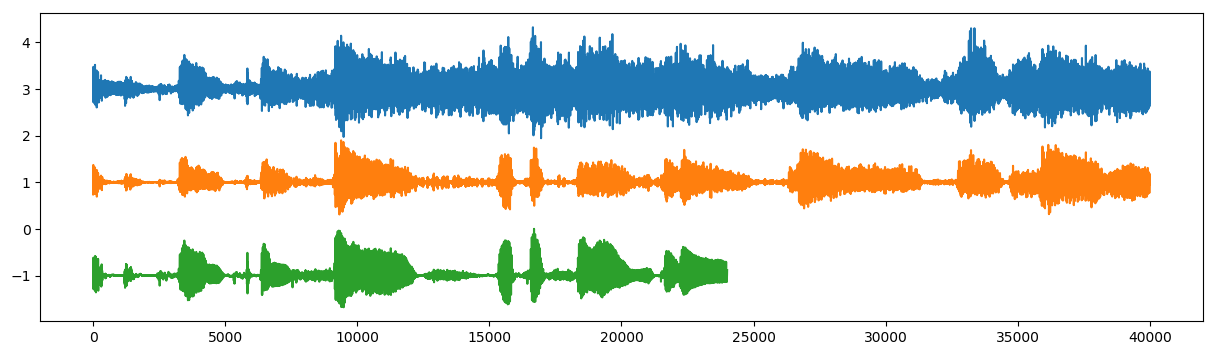

In [19]:
plt.figure(figsize=(15,4))
plt.plot(ymix.+3)
plt.plot(expand(μ_separated[1]).+1)
plt.plot(signal[1].-1)
audioplayers(signal[1], ymix, expand(μ_separated[1]), fs=fs_desired)

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQA2UEm9MNKOvfR4cL3UFq68X/QnuhCrBzyX/9I9ZnQaPjYvNT4YJgg+W7eJPZU+7Tz8xYi80R/FvLmbJL0Q5RS9DF+VO0MOED3t0FY9j0pRPdqJED0wJeM7Ub11vGF5Mr3M/4e9EnrUvZlf1b3xQgi+TvULvvJPAb7oAbe9/+YFvc+keDkxL6I7G7OOPb+4/D009cg9IiVsPbpojL2TZGu9FhCRvQ1lBr2Y4228FH+ZOwU6vj1gSQw+3AwzPoV5Dj7NP5c9oBcXPVMRmry0S8K8LpYMvWYEF716zgm8CM4MPbLDVj27dio9D3u7PKbjaDwdC0W8Or0uvchKkr03MO+9Czf1vdcJ870M5t69sOr6vUSHqL0+zGG9bUNMPDv8YbrqNI09x+rYPf0GsD24l549p8VsveH1Rr1bdJu9Lm0LvdIg4TclKo48ku+pPbRvET6fGyk+l8cZPskekz2k8uU8FYb1vAhUB70ymTa9NEdSvS8z3Ltj6t88D/VNPaZPTT2uEk09lHKmPJY0Lbz2DFK92Oy4vcgs470nU+y9xnXhvU+8yr0w+tm9ogeLvdf5KL12sgo8vKznu3pgSz1w9dg98NXaPbNdmj0R1TK9foFXvSZner3pNsy8WgocvFqCmDs4cIM9J/MHPqjmHT5B5BU+XAGAPedMEj3BMYO8ZFfQvKLdLL2hOgG9FKOxu33r5Dyi2Fs9MU9iPYBAUD0+2YE8ykC2vA/eYL0DHba9iMTgvQlb971ZQti9/SLkvcfWyb0fgKq9zCIvvYygezxzrQw7XGR7PYWpuD0y06o9k4CaPa7PNr0k1u28Hxs2vVYno7wkgYU8rSQyu7Wzvz1aRfU9DBMiPnbvFT7yrIo98gI+PTbG1buOttC7PdcNvW6o/bzS9WC8ui3YPONoLz225Co9BJ3lPLkuETwrzKu8bZ+FvcdPxr1/xQG+pUX2vc5E8b1w5+a9srXCvUAYiL2WmSW8JsmUPDjyPDxB75M9v87RPfb32T0qUEE9CSw5vWpa0rxhAP68nEB/u/Olqzs5Pk88j862PSjl/j2/pS8+g67kPUxqWT2XftQ7e6O+vNC/g7xZfCS9kP4hvb/7vrz5HIE8T4MqPc2IRD2qhbk8N4izu0pROL2nj3O9PQO9vb792L0mwc69AL7MvZMCvr2HmbC9OzuYvQMwa7xyiiE84H8GPXlK5j3OOs496WH2PYjRcTwue+y8pORMveXVUr3S+Pa7fKy6vFT3Mj3KzNQ9YQgdPqD5JT50pLE9Jy1OPSEjXLsm0fW75bUPvehKV73DNRO9bsBNvEsELD1fwVY9WZ5IPYaNajxQW5G8a6dovfSck71/ksu9MUfAvS2b4b1AYeG9D5rdvcTCvL0MSEq9lKG5umegejm1j009w4jNPRXZ1j31z5o9VvNWvJaHYrxQ3uO8HceqO0uqkTtaSg48ZM2IPfbG3z1ISQU+WAzsPX0cUT09BkI9mx0duxucgDuW0m+8sbKZvMU/Ibx+Xt47y/0jPaNmLz1nE8w8g6KCvIkJQL1dfnW9hfuuvQSi0r3vatC9FFTVvZQ92r2Jtby9HmKKvTF0xrz266c8750DvMY3uz1ilLE9dKnePeKhTj3mHAe9P1QLuzV6sbyDn608/BNOupFF0zsqWac9sCvUPWkoED7kLJ49rxgtPfB+jTz7tp66ne8HPOtg4ryqqoO8hy/buzuE+jw7OCw9eqfcPGG+zrttbVe9jOSUvVRjv71XF9a9eQzYvTCo172Mu7a9UbKdvScVdL2rmwe9qXq6u9bU/Lu0O1U9y2rCPUravT0mpZk9htPMu4e7Ory7P3+8/RYiOhR7tDoq5K47G5+cPXvd1D0lWRM+nOfIPR8BcD1zRtY8cWxAPDek/DuztD68ngWCO3vIfToqQOk81NEHPVSg4zwm6128itBdvRKjtb1HwdK9e2blvQuL4r2s0/W9swHcvQ6nsr0pZ4S9svQFvamSIbrDxqq8H8VdPXoijD2rMag91U5rPdOeGL1WXRc79ZP3vIxlHj1nzd48ldxuPVZv2T2Vy+s910UVPin2gz2/aCw9uEY0O/AlzbsKbpO5ualgvBTxPjy0HTA8d2k0PdtxRz0OsW483C6ZvFxKnr2DAM29iQ4GvorUEr43DQW+j6/avVb8w70LUJK9iWBDvYuMj7u1KG66feyWPCl8nT12fn897g2oPYkY0rzEC8i8Br0hvbBbhjykyTA9D0RPPeITxT238go+ZmwnPi8izD0kESI9vhgEPO1KCr2N0MG8FwdZvPTjgTtEtCc8mtUnPe3Dlj0GkYo94n6IPP6egL1Ulte9Xxf+vV+sHL7aFSO+pYX0vcWX4L1lqc29gFVWvX0xgrxdN7U8KYU5OwyinT2CgIk9beGJPZVp8rvPPeG88pFYvZbuAr2WZMM8vrVaPYNP1z13zu89yZolPsSaEj7V8Yk9B7hPPLJRAb3KeIu8CVokvUuJcLyHjSs8o1JiPawnrT3X6J89btVJPR1zxbxMIKy9L7oCvh0AGL7P4yi+q8cavi0fDL5qGt+9myeSvSOrb7yVt048khmBPPlgsj076Ig9QTuVPTBf87yc1o29D5WMvX/rQb3nqmE8TA/pPBpn1D1gifQ9gogsPl24JD4/IbU9JPQKPXbadbyHV5q8eEwcvWlG8bwoDyO79hX2PAjzoz1nUaw9nWqGPUpytzwK9i+9IoG6vQfWD77i7CO+guIovkTqLb6cO/u9xoe0vf7WQrweE748xyTHOouwxz2ejI89GsfFPaeZg7zTcJe9dSqJvacYhb0WOIE8c3B5PIDkmD01Jeg9GHYrPrqVMz7CQMk9DkQJPQikebyWnww5Ws2UvERhv7yk+5C8iTiiPOorfz3Pm6E91R2BPTHZBzqqMxW9FWuvvf4B2L3OR/69ZjUmvsafIL4+sQm+km2NvWo94rxtx368wUWKuvKSkT3i6Mw9XPCkPZ68abwLqjm9rLVNvQeeEr1Z90G7bzzjugOihD0d1No9JwAxPjl5FD4WX7Q9rgATPayR2TtkWlw8v9SUOygp0Lv254q7/Z4FPb7Cbz2LZZc989guPUtGCrzYpSG9ZwetvWe6y70SkwK+SukMvuqJ9b3mUti9NyUgvQPbk7w/DeC8jl+XO6aVhj2/dZ09M2ZKPWRyFb2ge0u9bpCDvUUsQ7yv9m47t7wUu+obOT22Td099PgZPmD36z1tZY095bi+OxxAs7pkAo2704oVOxdEOryxgag7J3uBPVNAlz1185U96/u6PEtv8LyZ53K937SevTQ7qb2+1ei9n9n7vb4k6b3k0pO9aNyvvL5/djvTCcK8e9UfPR/icj0uysE9Pgcfu41ZXL0oZ5W9WH9dvcKW3bsvjQy89IIuPRA/lD1AZwI+bkUPPjQ0qj2TW+A8m6C5vDc6N7yOQKC8ODwOvIndFrxeOyY9GqqdPbhFuT2Iopg91waDOc7zEr0s04G9okebvZCgxL3+EfO9U87Sve6Pu730IAm9UJDRO+j22ryAHe87Zlc+PSoFmj0rMnc9JYUsvd5Nm73K6MK9SRbbvGJTv7tqiye8gTY/PWeipz39JhQ+1+PsPSa1Wj1GN266hUwxvIxHobsssYm8GteSvAVDBbxyTFk9ShO3PeY00z2iu5E9NIgTvOvf47xzDIC91EO7vdB/4L2dkvi9vxfjvfpRaL11UpW7AEZEPBpFdbv1+wY9DrawPYpzxT3rVOE8tD9ave5xxL0atKO90SKjvNeIgLyBV388zu5TPUxBAD5rhB8+Z0zHPUQqKD1Kloa8ZdtXuzVyk7zMYvm8ao4SvVueE7xMtVM9tWONPUjdsT0dQSA9sliCujAqqbxtRXK9VkK8vS2Q9b1ZS

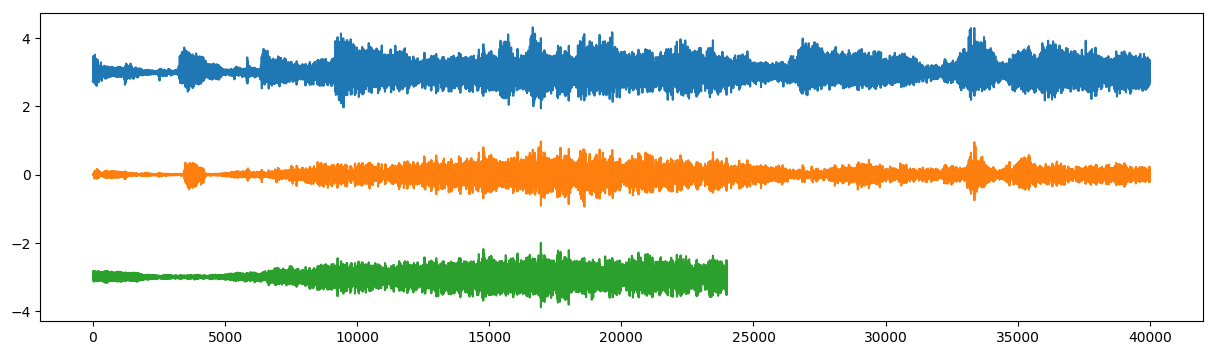

In [20]:
plt.figure(figsize=(15,4))
plt.plot(ymix.+3)
plt.plot(expand(μ_separated[2]))
plt.plot(signal[2].-3)
audioplayers(signal[2], ymix, expand(μ_separated[2]), fs=fs_desired)

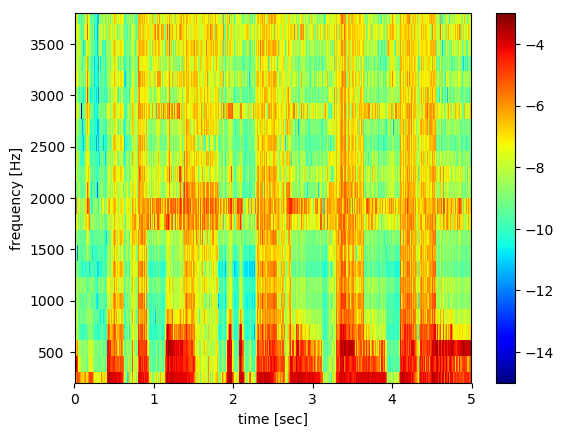

In [21]:
plot_spectrogram(spectrogram(expand(μ_separated[1]), bufsize, bufsize-stepsize_train, fs=fs_desired), fs_desired)
plt.ylim(200,3800)
plt.colorbar()
plt.clim(-15,-3)

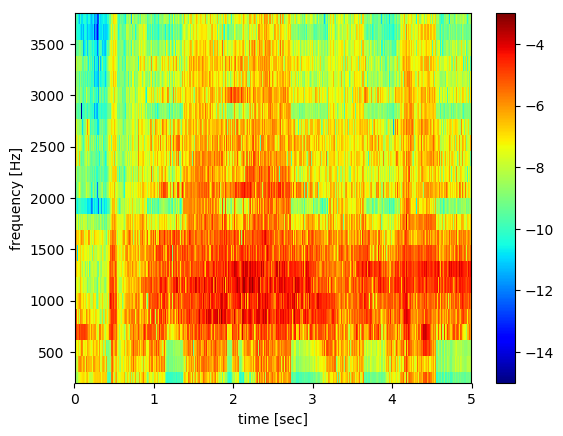

In [22]:
plot_spectrogram(spectrogram(expand(μ_separated[2]), bufsize, bufsize-stepsize_train, fs=fs_desired), fs_desired)
plt.ylim(200,3800)
plt.colorbar()
plt.clim(-15,-3)

In [23]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t, signal[k], label="true")
    ax[k,1].plot(t, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,1].set_xlim([0, duration]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k]), ax[k,1].legend()
    
    # plot zoomed-in version of signal
    ax[k,2].plot(t, signal[k], label="true")
    ax[k,2].plot(t, μ_separated[k], label="predicted")
    ax[k,2].fill_between(t, μ_separated[k] .- σ_separated[k], μ_separated[k] .+ σ_separated[k], alpha=0.3, color="orange")
    ax[k,2].set_xlim([1, 1.01]), ax[k,2].set_ylim(-1,1), ax[k,2].set_xlabel("time [sec]"), ax[k,2].set_ylabel("signal"), ax[k,2].grid(), ax[k,2].set_title(sound_files[k]), ax[k,2].legend()

end

# save figure
filename_figures1 = folder_figures*"/AR_time_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(AR_order, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
plt.savefig(filename_figures1)

UndefVarError: UndefVarError: t not defined

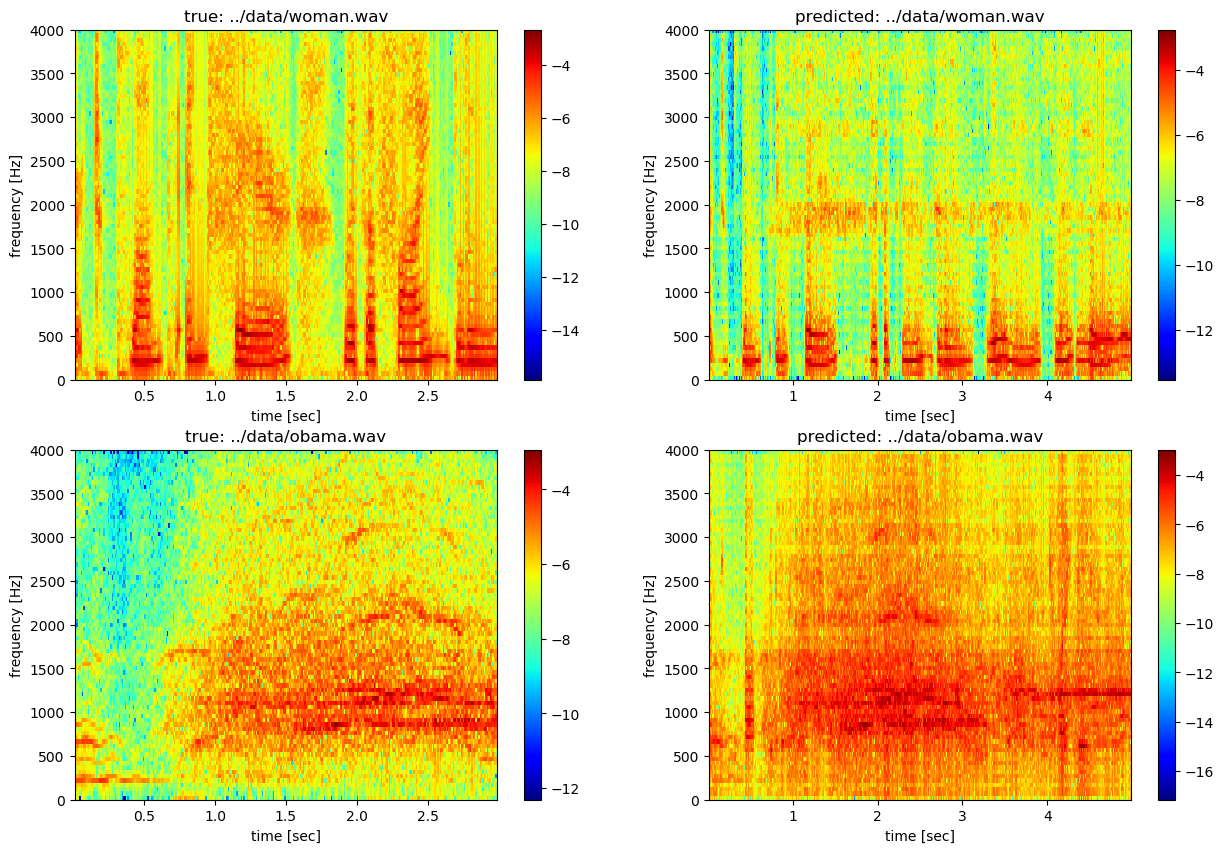

In [24]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot true spectrogram
    plot_spectrogram(spectrogram(expand(signal[k]), 160, 80, fs=fs_desired), fs_desired, ax=ax[k,1], colorbar=true)
    ax[k,1].set_title("true: "*sound_files[k])
    
    # plot predicted spectrogram
    plot_spectrogram(spectrogram(expand(μ_separated[k]), 160, 80, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true)
    ax[k,2].set_title("predicted: "*sound_files[k])

end

# save figure
#filename_figures2 = folder_figures*"/GSMM_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*string(nr_clusters, pad=2)*"_"*@sprintf("%.1E", γ_meas_sep)*".png"
#plt.savefig(filename_figures2)